\begin{center} 
Chun-Yuan (Scott) Chiu 
\end{center}
\begin{center} 
chunyuac@andrew.cmu.edu 
\end{center}

# 1. {-}

## (a) {-}

Judging from the below time series plot, the 3-month treasury rates is most likely not stationary. A stationary time series has constant mean which the plot does not seem to feature. 

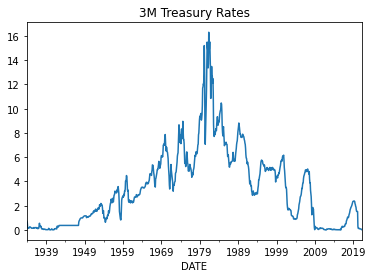

In [1]:
import pandas_datareader.data as web
import datetime

start = datetime.datetime(1934, 1, 1)
end = datetime.datetime(2021, 3, 1)

tb3ms = web.DataReader('TB3MS', 'fred', start, end)
tb3ms.plot(legend=None, title='3M Treasury Rates')
pass

## (b) {-}

The augmented Dickey-Fuller test on the original time series found no evidence to reject the hypothesis that it is unit-root non-stationary. 

In [2]:
import numpy as np
import statsmodels.tsa.api as smt

smt.stattools.adfuller(np.diff(tb3ms.values.ravel(), n=0))

(-1.99768609451749,
 0.2875885868267768,
 21,
 1025,
 {'1%': -3.43674585579594,
  '5%': -2.8643638720413227,
  '10%': -2.5682735516954196},
 532.4445434006693)

Taking difference once, the null hypothesis is rejected now. There is no unit root presented. 

In [40]:
smt.stattools.adfuller(np.diff(tb3ms.values.ravel(), n=1))

(-7.807198416577612,
 7.228526169719172e-12,
 20,
 1025,
 {'1%': -3.43674585579594,
  '5%': -2.8643638720413227,
  '10%': -2.5682735516954196},
 535.0645589781107)

## (c) {-}

We fit an ARIMA model by taking difference of the original time series once (as suggested by the Dickey-Fuller test results above) and then fit an ARMA$(p, q)$ model to it. The fitting results and the performances are reported in part (d). Here we present the best $(p, q)$ pairs by model selection methods. 

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
import numpy as np
import statsmodels.tsa.api as smt

y = np.diff(tb3ms.values.ravel(), n=1)
res = smt.stattools.arma_order_select_ic(y, ic=['aic', 'bic'], trend='nc')
print('AIC min order: ', res.aic_min_order)
print('BIC min order: ', res.bic_min_order)

AIC min order:  (4, 2)
BIC min order:  (3, 2)


## (d) {-}

Below ACF plots suggest that there are unmodeled autocorrelations with both ARMA(3, 2) and ARMA(4, 2). 

In [2]:
from statsmodels.tsa.arima_model import ARMA
from pandas import Series
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt

def tsplot(ts, title, acf_ylim=(-0.2, 0.2)):
    fig = plt.figure(figsize=(10, 5))
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    pacf_ax = plt.subplot2grid(layout, (1,1))
    acf_ax = plt.subplot2grid(layout, (1,0))

    Series(ts).plot(ax=ts_ax)
    smt.graphics.plot_acf(ts, ax=acf_ax)
    smt.graphics.plot_pacf(ts, ax=pacf_ax)
    ts_ax.set(title=title)
    pacf_ax.set(ylim=acf_ylim)
    acf_ax.set(ylim=acf_ylim)

    plt.tight_layout()
    plt.show()

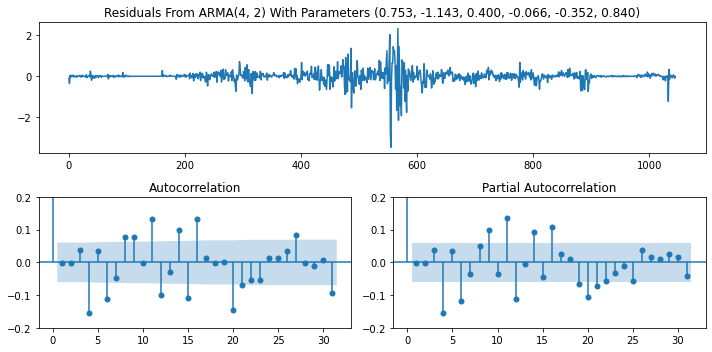

In [17]:
model42 = ARMA(y, (4, 2)).fit(trend='nc', disp=0)
tsplot(ts=model42.resid, title="Residuals From ARMA(4, 2) With Parameters (%s, %s, %s, %s, %s, %s)"%tuple('%.3f'%param for param in model42.params))

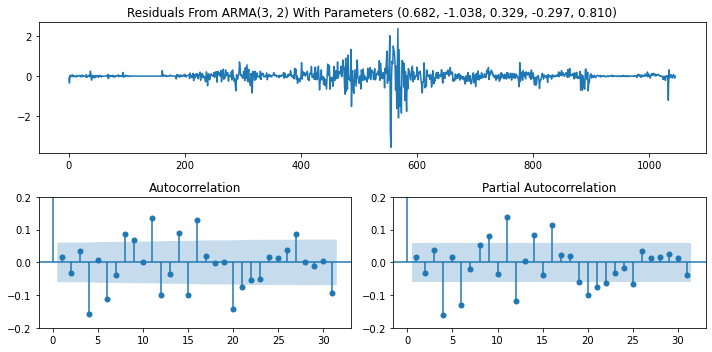

In [18]:
model32 = ARMA(y, (3, 2)).fit(trend='nc', disp=0)
tsplot(ts=model32.resid, title="Residuals From ARMA(3, 2) With Parameters (%s, %s, %s, %s, %s)"%tuple('%.3f'%param for param in model32.params))

Part of the unmodeled autocorreltions could be explained by the seasonal effect. Since we are working with monthly data, it makes more sense to see relatively stronger autocorrelations at lags that are multiple of 3 (one quarter is 3 months), as the ones at lag 6 and 12. For some reason the autocorrelation at lag 4 is pretty strong too. 

In [20]:
tb3ms.head(5)

,TB3MS
DATE,
1934-01-01,0.72000000
1934-02-01,0.62000000
1934-03-01,0.24000000
1934-04-01,0.15000000
1934-05-01,0.16000000


The Ljung-Box test suggests that for both ARMA(4, 2) and ARMA(3, 2) models we have $\rho(1) = \rho(2) = \rho(3) = 0$ but $\rho(4)\neq 0$, which is consistent as our earlier observation. 

In [19]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.8f'%x)
pd.merge(acorr_ljungbox(model42.resid, lags=10, return_df=True), acorr_ljungbox(model42.resid, lags=10, return_df=True), 
         left_index=True, right_index=True, suffixes=(' (4, 2)', ' (3, 2)'))

,"lb_stat (4, 2)","lb_pvalue (4, 2)","lb_stat (3, 2)","lb_pvalue (3, 2)"
1,0.00175712,0.96656408,0.00175712,0.96656408
2,0.00396460,0.99801966,0.00396460,0.99801966
3,1.41975431,0.70091082,1.41975431,0.70091082
4,26.71571571,0.00002269,26.71571571,0.00002269
5,27.88686461,0.00003830,27.88686461,0.00003830
6,40.83172156,0.00000031,40.83172156,0.00000031
7,43.16696096,0.00000031,43.16696096,0.00000031
8,49.30143285,0.00000006,49.30143285,0.00000006
9,55.71756196,0.00000001,55.71756196,0.00000001
10,55.71901170,0.00000002,55.71901170,0.00000002


# 2. {-}

## (a)(c) {-}

(Note: The same experiment run on QQQ (an ETF tracking the Nasdaq-100 index) gives worse results and the residual time series will not pass the Ljung-Box test. Below is a redo with AAPL.)

We examine the apple stock (AAPL). We see that its log-return time series has some significant nonzero autocorreltions at lower lags in the below ACF plots. 

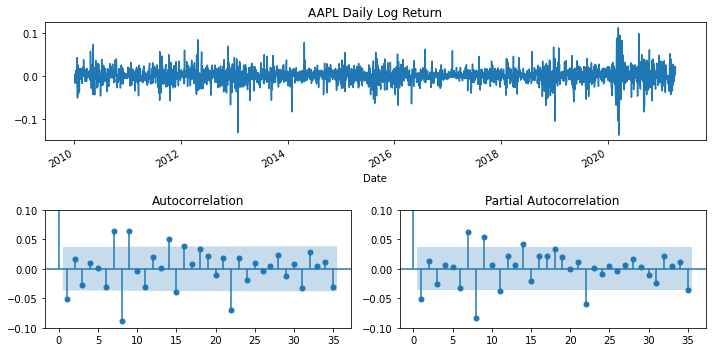

In [22]:
import pandas_datareader as pdr
import numpy as np

start = '2010-01-01'
end = '2021-04-09'
adjclose = pdr.get_data_yahoo('AAPL', start, end)['Adj Close']
logret = np.log(adjclose/adjclose.shift(1)).dropna()

tsplot(logret, 'AAPL Daily Log Return', acf_ylim=(-0.1, 0.1))

## (b) {-}

The augmented Dickey-Fuller test rejects the null hypothesis of the existence of any unit root. No differencing is needed. 

In [19]:
import numpy as np
import statsmodels.tsa.api as smt

smt.stattools.adfuller(np.diff(logret.values.ravel(), n=0))

(-10.8583775106619,
 1.4676838705876044e-19,
 21,
 2813,
 {'1%': -3.432676796065778,
  '5%': -2.862568016428968,
  '10%': -2.5673172444287347},
 -14656.315361729234)

## (d) {-}

ARMA(4, 2) minimizes both AIC and BIC. 

In [20]:
res = smt.stattools.arma_order_select_ic(logret, ic=['aic', 'bic'], trend='nc')
print('AIC min order: ', res.aic_min_order)
print('BIC min order: ', res.bic_min_order)

AIC min order:  (4, 2)
BIC min order:  (4, 2)


## (e) {-}

We fit a few ARMA models to the log-return, with $(p, q)$ values close to the optimal models suggested by the above model selection results. Based on the ACF plots, we consider ARMA(4, 2) the best model as its autocorrelations at all lags are insignificant. 

In ARMA(4, 2), the estimated coefficients $\hat \phi_3$ and $\hat \phi_4$ are small. We therefore tried to reduce the AR order, but then the ACF becomes worse. In the end we stay with ARMA(4, 2).

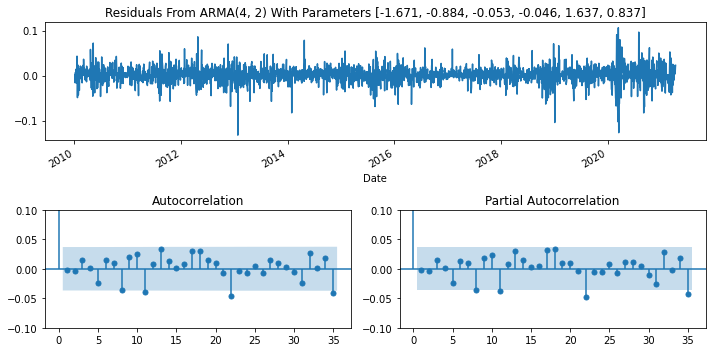

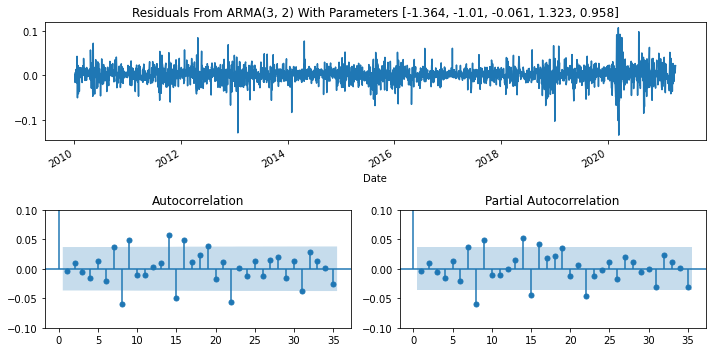

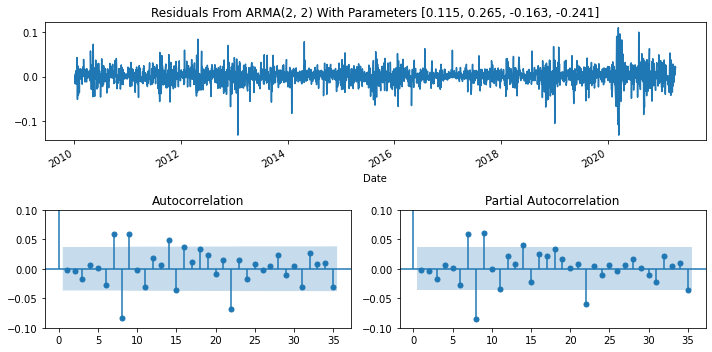

In [29]:
from IPython.display import Markdown, display

for p, q in [(4, 2), (3, 2), (2, 2)]:
    model = ARMA(logret, (p, q)).fit(trend='nc', disp=0)
    tsplot(ts=model.resid, title=f"Residuals From ARMA{(p, q)} With Parameters {[round(param, 3) for param in model.params.values]}", acf_ylim=(-0.1, 0.1))
    print()

The augmented Dickey-Fuller test indicates that the residual time series of the fitted ARMA(4, 2) model has no unit root. 

In [7]:
import statsmodels.tsa.api as smt

model42 = ARMA(logret, (4, 2)).fit(trend='nc', disp=0)
smt.stattools.adfuller(model42.resid)

(-53.35787102792967,
 0.0,
 0,
 2834,
 {'1%': -3.4326595388027648,
  '5%': -2.8625603948435945,
  '10%': -2.5673131867249634},
 -14667.159337066136)

The Ljung-Box test indicates that the residuals have autocorrelation $\rho(j) = 0$ for all $j$. We conclude that ARMA(4, 2) is a reasonably good model to capture temporal correlations in the log-return of AAPL. 

In [8]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(model42.resid, return_df=True)

,lb_stat,lb_pvalue
1,0.024031,0.876805
2,0.081024,0.960297
3,0.728844,0.866400
4,0.732039,0.947320
5,2.303406,0.805767
6,2.868205,0.825198
7,3.135452,0.872195
8,6.821084,0.556054
9,7.871145,0.547182
10,9.569090,0.479076


Interestingly the residual time series of the fitted ARMA(4, 2) model preserves the same volatility cluster pattern as the log return time series. 

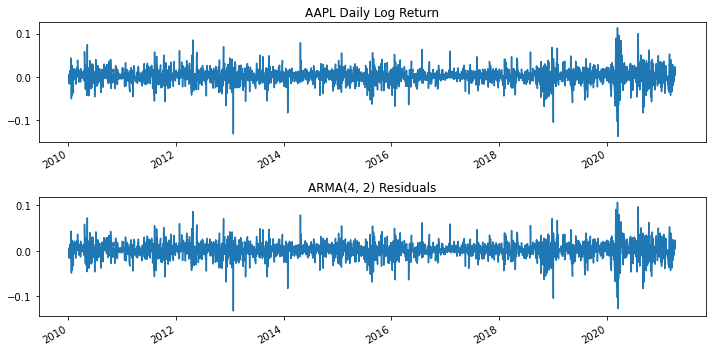

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))
logret.plot(title='AAPL Daily Log Return', ax=ax1)
model42.resid.plot(title='ARMA(4, 2) Residuals', ax=ax2)
ax1.set(xlabel=None)
ax2.set(xlabel=None)
plt.tight_layout()

# 3. {-}

The estimated model is 
\begin{align*}
Y_t &= 100.1 + 0.5 (Y_{t-1} - 100.1) + 0.1 (Y_{t-2} - 100.1) + \epsilon_t, 
\end{align*}
where $\epsilon_t$ is a white noise so $E[\epsilon_t] = 0$ for all $t$.
Plugging in $t=n+1$ we obtain 
\begin{align*}
Y_{n+1} &= 100.1 + 0.5 (Y_{n} - 100.1) + 0.1 (Y_{n-1} - 100.1) + \epsilon_{n+1} \\
&= 100.1 + 0.5(102.3 - 100.1) + 0.1(99.5 - 100.1) + \epsilon_{n+1}. 
\end{align*}
The best forecast of $Y_{n+1}$ is its expectation (conditional on $\mathcal F_{n}$)
\begin{align*}
100.1 + 0.5(102.3 - 100.1) + 0.1(99.5 - 100.1) = 101.14, 
\end{align*}
which we denote by $\hat Y_{n+1}$.


Now in the estimated model we plug in $t=n+2$ to obtain
\begin{align*}
Y_{n+2} &= 100.1 + 0.5 (Y_{n+1} - 100.1) + 0.1 (Y_{n} - 100.1) + \epsilon_{n+2} \\
&= 100.1 + 0.5(Y_{n+1} - 100.1) + 0.1(102.3 - 100.1) + \epsilon_{n+2}. 
\end{align*}
The best forecast of $Y_{n+2}$ is
\begin{align*}
E[Y_{n+2} | \mathcal F_{n}] &= E[100.1 + 0.5(Y_{n+1} - 100.1) + 0.1(102.3 - 100.1) + \epsilon_{n+2} | \mathcal F_{n}]\\
&= 100.1 + 0.5 E[Y_{n+1}| \mathcal F_{n}] - 0.5\times 100.1  + 0.1(102.3 - 100.1) + E[\epsilon_{n+2} | \mathcal F_{n}]\\
&= 100.1 + 0.5\times 101.14 - 0.5\times 100.1 + 0.1(102.3 - 100.1)= 100.84, 
\end{align*}
which we denote by $\hat Y_{n+2}$.
This is equivalent to just plugging in previous forecasts to the estimated model and set $\epsilon_{n+2}$ to zero. 


Similarly, we can compute the best forecast of $Y_{n+3}$ as follows: 
\begin{align*}
\hat Y_{n+3} &= 100.1 + 0.5 (\hat Y_{n+2} - 100.1) + 0.1 (\hat Y_{n+1} - 100.1)\\
&= 100.1 + 0.5(100.84 - 100.1) + 0.1(101.14 - 100.1) = 100.574.
\end{align*}

# 4. {-}

The estimated model is 
\begin{align*}
Y_t &= \hat\mu + \epsilon_t + \hat\theta_1\epsilon_{t-1} + \hat\theta_2\epsilon_{t-2}\\
&= 45 + \epsilon_t + 0.3\epsilon_{t-1} - 0.15\epsilon_{t-2}.
\end{align*}
Plugging in $t=n+1$, we obtain
\begin{align*}
Y_{n+1} = 45 + \epsilon_{n+1} + 0.3\epsilon_{n} - 0.15\epsilon_{n-1}.
\end{align*}
The best forecasts of $Y_{n+1}$ is 
\begin{align*}
\hat Y_{n+1} = E[Y_{n+1} | \mathcal F_n] = 45 + E[\epsilon_{n+1} |\mathcal F_n] + E[0.3\epsilon_{n} - 0.15\epsilon_{n-1} | \mathcal F_n]
\end{align*}
Given the filtration $\mathcal F_n$, we have the realization $\hat\epsilon_{n}=1.5$ and $\hat\epsilon_{n-1}=-4.3$, and we also know $E[\epsilon_{n+1} |\mathcal F_n] = 0$ as $\epsilon_t$ is a white noise process. Thus we have
\begin{align*}
\hat Y_{n+1} = 45 + 0.3\times 1.5 + 0.15\times 4.3 = 46.095.
\end{align*}


To find the forecast of $Y_{n+2}$, plug $t=n+2$ into the estimated model to obtain
\begin{align*}
Y_{n+2} = 45 + \epsilon_{n+2} + 0.3\epsilon_{n+1} - 0.15\epsilon_{n}.
\end{align*}
With the realization $\hat\epsilon_{n}=1.5$ and the best estimates $\hat\epsilon_{n+2}=\hat\epsilon_{n+1}=0$, we have 
\begin{align*}
\hat Y_{n+2} = 45 - 0.15\times 1.5 = 44.775.
\end{align*}

